In [2]:
import sta_clustering_core

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
print(sta_clustering_core.__version__)

2.0.3


In [4]:
print(pd.__version__)

1.1.0


#### Preparation
* Load data into Python
* Drop empty or very short texts
* Choose number of clusters (e.g. 12)

#### Clustering
* Create the *feature matrix* by converting the text content into a word frequency map with tf-idf weighting
* Cluster the documents using non-negative matrix factorisation (NMF)
* Inspect the resulting compressed matrices to determine
    * Cluster assignment of each document
    * Cluster size
    * Top words for each cluster
    
#### Visualise the results
* Confusion matrix
* Positions of clusters in the latent space (pyLDAvis)

In [5]:
from typing import List
from sta_clustering_core.core.datamodel import RefCase

def df_to_refcases(df: pd.DataFrame) -> List[RefCase]:
    """Converts the dataframe to RefCases, the internal format for STA"""
    result = []
    for _idx, row in df.iterrows():
        try:
            result.append(RefCase(
                _idx,  # row['Case Number'],
                row['Machine Translation (beta): English'],  # row['Subject'],
                '',  # row['Description'],
                '',  # row['Solution Description'],
                [],  # parse_entity_list(row['Subject_entities']),
                [],  # parse_entity_list(row['Desc_entities']),
                [],  # parse_entity_list(row['Soln_entities']),
                '',  # row['Product Family'],
                ''  # row['Equipment: Serial Number']
            ))
        except UnicodeError as ue:
            print(ue)
            print(row)
            
    return result

In [13]:
data_path = '/home/z0017wrp/work/projects/sges_sop_it/ct mvp data from teams 20200811/CT MVP/'
files = [
    ('sges1_2019', 'SGES 1 2019 Q3 English Beta.xlsx'),
    ('sges2_2019', 'SGES 2 2019 Q4 English Beta.xlsx'),
    ('sges3_2020', 'SGES 3 2020 Q1 English Beta.xlsx')
]

data_by_survey_code = []
for survey_code, filename in files:
    datafr = pd.read_excel(data_path+filename)
    datafr = datafr.assign(survey_code=survey_code)
    data_by_survey_code.append(datafr)
    
data = pd.concat(data_by_survey_code)

print(f'Loaded {data.shape[0]} records')
print(data.columns)
data.set_index('id', inplace=True)

# get rid of NAs in the Action Field - replace with "missing"
# data['Action Field'] = data['Action Field'].fillna('Missing')

data.dropna(axis=0, subset=['Machine Translation (beta): English'], inplace=True)
print(f'After dropping empty records, we have {data.shape[0]} records')

# Drop short documents, since they are likely to end up as empty docs after projection into feature space
min_text_length_chars = 20
data = data[data['Machine Translation (beta): English'].map(len) > min_text_length_chars]
print(f'After dropping short texts, we have {data.shape[0]} records')

refcases = df_to_refcases(data)
print(f'Loaded {len(refcases)} RefCases')


Loaded 12601 records
Index(['id', 'Sentiment', 'Category', 'Type', 'Sub Category',
       'Machine Translation (beta): English', 'Detected Language',
       'survey_code'],
      dtype='object')
After dropping empty records, we have 12515 records
After dropping short texts, we have 11482 records
Loaded 11482 RefCases


In [14]:
display(data.Category.value_counts())
display(pd.crosstab(data.Category, data.survey_code))

Advantages / Disadvantages about Working at Siemens    1959
Personal & Professional Development                    1191
Work-Life-Balance                                      1171
Leadership Behaviour                                   1099
Corporate Culture & Working Environment                1087
Creating Customer Value Fast                            910
Remuneration and Social Benefits                        810
Operational Excellence                                  662
Take and Give Responsibility                            496
Innovate and Grow                                       490
Collaborative Global IT                                 454
Embrace Roles of IT Operating Model                     445
Health & Safety                                         421
Strategy & Direction                                    270
Other Topics                                             17
Name: Category, dtype: int64

survey_code,sges1_2019,sges2_2019,sges3_2020
Category,,,
Advantages / Disadvantages about Working at Siemens,0,1959,0
Collaborative Global IT,0,217,237
Corporate Culture & Working Environment,401,413,273
Creating Customer Value Fast,0,483,427
Embrace Roles of IT Operating Model,0,223,222
Health & Safety,124,159,138
Innovate and Grow,0,244,246
Leadership Behaviour,378,407,314
Operational Excellence,254,244,164


## Configuration for clustering

In [15]:
from sta_clustering_core.core.config_handling import pretty_print_config
import configparser
import pkgutil

# Construct the config object
config = configparser.ConfigParser()

# first, read the defaults
config.read_string(pkgutil.get_data('sta_clustering_core.resources', 'defaults.conf').decode())

# then add further config choices
config.set('clustering', 'output.file_clusters', 'None')
config.set('clustering', 'output.file_cases', 'None')
config.set('clustering', 'output.per_cluster_filepattern', 'None')
config.set('clustering', 'output.cluster_distribution_filename', 'None')

num_clusters = 50
config.set('clustering', 'cluster.num_clusters', str(num_clusters))
    
pretty_print_config(config)

[clustering]
  weight.subj_text:	1
  weight.subj_ent:	1
  weight.desc_text:	1
  weight.desc_ent:	1
  weight.soln_text:	1
  weight.soln_ent:	1
  tokenisation.min_ngram:	2
  tokenisation.max_ngram:	3
  tokenisation.drop_list:	turbin|siemen
  tokenisation.do_stemming:	True
  tokenisation.remove_stopwords:	True
  tokenisation.text_language:	en
  features.min_doc_length:	0
  features.use_tf_idf:	True
  features.normalise:	True
  features.min_df:	1
  features.num_best_features:	10000
  features.parallelisation:	1
  cluster.num_clusters:	50
  cluster.algorithm:	nmf
  cluster.write_matrices:	False
  input.sep:	tab
  logging.thresholds.min_vocab_overlap:	0.5
  logging.thresholds.norm_ent_overlap:	0.5
  output.num_top_words:	10
  output.list_sep:	|
  output.file_clusters:	None
  output.file_cases:	None
  output.per_cluster_dir:	per_cluster
  output.per_cluster_filepattern:	None
  output.feature_freqs:	None
  output.cluster_distribution_filename:	None
  store.model.filename:	model.tar.gz


In [104]:
with open('config_sges123_k50.conf', 'w') as configfile:    # save
    config.write(configfile)

## Train the clustering model

In [16]:
from sta_clustering_core.core.interface import main_aux_from_data

model_version = 'sges_2020'
mp = main_aux_from_data(refcases, config, model_version, draw_plot=None)

/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWar

In [18]:
mp.persist('sges123_k50.tar.gz')

## Inspect the top words and cluster sizes

Text(0.5, 1.0, 'Distribution of cluster sizes')

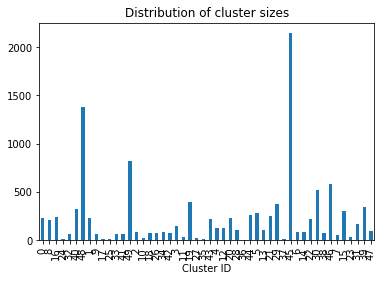

In [19]:
cluster_assignments = pd.DataFrame(mp.cluster_label_for_cases.items(), columns=['id', 'cluster_id'])
cluster_assignments = cluster_assignments.set_index('id')

cluster_sizes = cluster_assignments.cluster_id.value_counts(sort=False)
axes = cluster_sizes.plot.bar()
axes.set_xlabel('Cluster ID')
axes.set_title('Distribution of cluster sizes')



In [21]:
# write the cluster assignments to file
cluster_assignments.to_csv('cluster_assignments_sges123_k50.csv')

In [38]:
data.shape

(11482, 7)

In [33]:
predicted_data = data.join(cluster_assignments)
predicted_data.iloc[0]

Sentiment                                                                           Keep
Category                               Advantages / Disadvantages about Working at Si...
Type                                                        "Recommend Siemens" Comments
Sub Category                                                                         NaN
Machine Translation (beta): English    Well paid, Free working time, More Learning Op...
Detected Language                                                                     en
survey_code                                                                   sges2_2019
cluster_id                                                                            44
Name: 0000ecc475b7ea5c786b7d0b8e1e560d4c004869, dtype: object

In [37]:
predicted_data.shape

(11482, 8)

In [22]:
# get the cluster sizes along with their top words

info = []
for i in range(num_clusters):
    cluster_i_info = {
        'cluster_id': i,
        'cluster_size': cluster_sizes[i]   
    }
    for idx, word in enumerate(mp.cluster_top_words[i]):
        cluster_i_info['top_word_%s' % idx] = word
    info.append(cluster_i_info)

cluster_info = pd.DataFrame(info)
cluster_info = cluster_info.set_index('cluster_id')

cluster_info


,cluster_size,top_word_0,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5,top_word_6,top_word_7,top_word_8,top_word_9
cluster_id,,,,,,,,,,,
0,228,languag current,support autom,translat engin,current support autom,current support,info languag,info languag current,languag current support,autom translat,autom translat engin
1,225,work life,work life balanc,life balanc,excel work life,life balanc flexibl,balanc flexibl,condit work life,great work life,condit work,flexibl work life
2,82,good work environ,good work,work environ,keep good work,work environ manag,good facil,keep good,environ manag,compani good work,environ corpor cultur
3,148,flexibl work hour,work hour,flexibl work,work hour possibl,hour possibl,balanc flexibl work,work hour homeoffic,hour homeoffic,life balanc flexibl,balanc flexibl
4,123,work person,work person life,person life,balanc work person,balanc work,person life balanc,maintain balanc work,maintain balanc,good balanc work,great balanc work
5,284,profession develop,person profession,person profession develop,opportun person profession,opportun person,good person profession,good person,support person profession,focus person profession,support person
6,88,work condit,good work condit,good work,condit work,work condit work,condit work life,work condit good,condit good,environ work condit,excel work condit
7,54,flexibl work time,work time,flexibl work,work time possibl,time possibl,work time model,time model,possibl flexibl work,thank flexibl work,good possibl flexibl
8,209,home offic,possibl home offic,possibl home,home offic good,offic good,work hour possibl,hour possibl home,hour possibl,offic work,offic twice week


In [113]:
sample_cluster = 42
max_docs = 50
for idx, row in list(predicted_data[predicted_data.cluster_id == sample_cluster].iterrows())[:max_docs]:
    print(f'{idx}  {row["Detected Language"]}: {row["Machine Translation (beta): English"]}')

08e26ac12f8db21d98876013ad95fdb4408bbf65  de: Good work-life balance possible due to flexitime. However, little opportunities at the site ERL S itself to relax sometimes. little green areas.
0d2dd1210a37a5ac9c3338bbf7a555f7ecb1e830  en: Good work life balance
0de2274df738bdb118faf9e836d7804745f7bec2  de: -Nice colleagues -Good work life balance -Super salary
15c98bc592ebd2e88a42fb8117eba717f1b1c134  en: Again, we are running out of time regarding some team changes and I'm not confident that all the data we will have access is the one that we should have in order to keep the good work.
208d8af1f430c5c2847b961554469ddde05e5f55  de: A lot is offered for the employees (e.g. #developme, Pluralsight,...)
20e6c50f329221695565dcd4a214c2c1abb6776f  en: Innovation; Challenging Projects; Recent Technologies; Conditions (like HO);
2d389b7d7125f805ae3b581fde80a68d4acec98a  en: A good work life balance exists within Siemens
326e83c7f8f8d17e0032e044044288b5cb985821  en: Sometimes this is not possible

In [57]:
data['Detected Language'].value_counts()

en       4737
de       3632
pt       2263
es        416
fr         59
zh         46
it         44
ru         19
cs         18
tr         16
hu          8
ro          6
gl          4
zh-TW       2
ca          1
sr          1
ht          1
da          1
hr          1
nl          1
mg          1
Name: Detected Language, dtype: int64

In [23]:
# write the cluster info to file
cluster_info.to_csv('cluster_info_sges123_k50.csv')

## Draw the confusion matrix

{'Advantages / Disadvantages about Working at Siemens': 0, 'Personal & Professional Development': 1, 'Work-Life-Balance': 2, 'Leadership Behaviour': 3, 'Corporate Culture & Working Environment': 4, 'Creating Customer Value Fast': 5, 'Remuneration and Social Benefits': 6, 'Operational Excellence': 7, 'Take and Give Responsibility': 8, 'Innovate and Grow': 9, 'Collaborative Global IT': 10, 'Embrace Roles of IT Operating Model': 11, 'Health & Safety': 12, 'Strategy & Direction': 13, 'Other Topics': 14}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49}
[[ 16.  54.  35.  53.  25.  15.  52.  14.  39.  20.   2.   5.  22.  23.
   14.  35.  25.   0.  32.  24.  72.  45. 

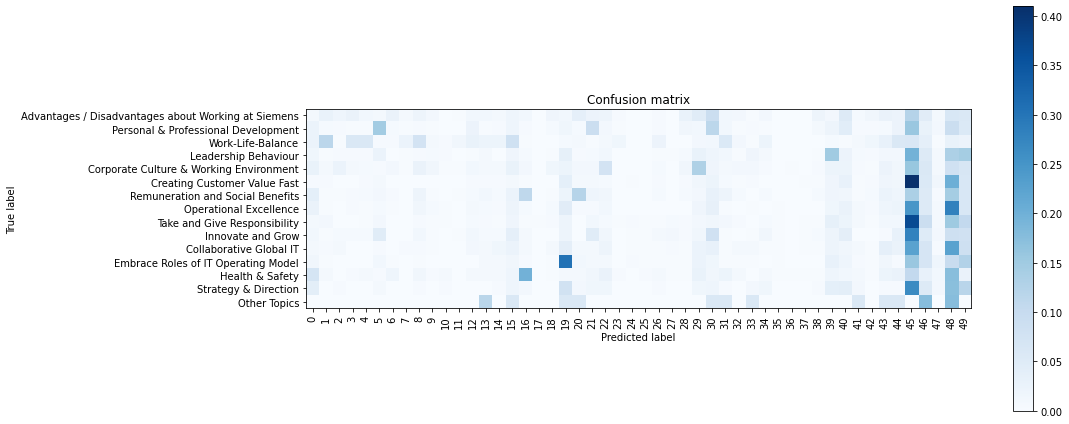

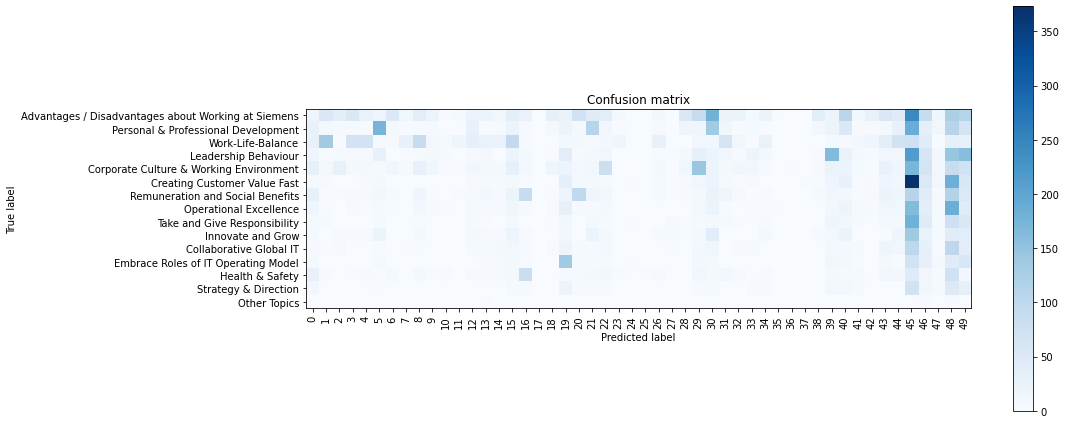

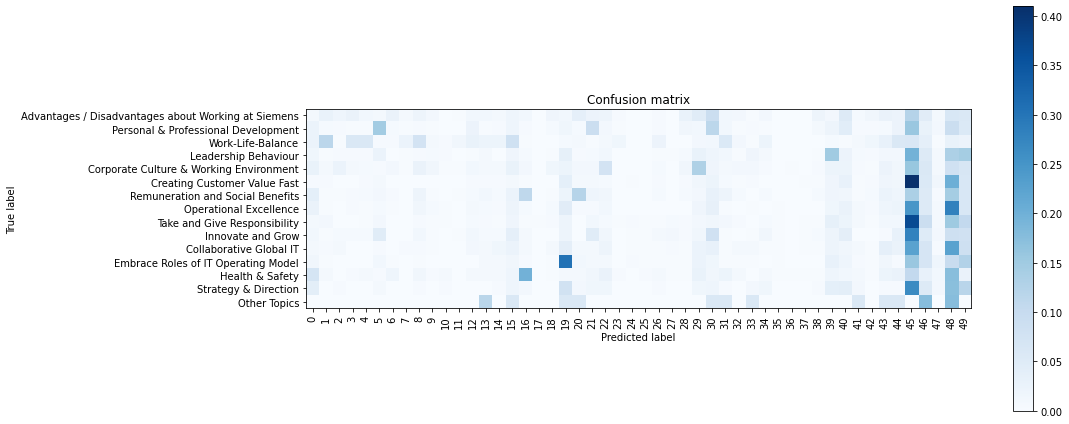

In [27]:
# Confusion matrix

import numpy as np
from typing import Tuple
from sklearn.preprocessing import normalize


def non_square_confusion_matrix(actual: List, predicted: List, 
                                actual_ordered: List=None, 
                                predicted_ordered: List=None) -> Tuple[np.ndarray, List[str], List[str]]:
    """Computes a confusion matrix for non-identical classes."""
    assert len(actual) == len(predicted)
    
    if actual_ordered:
        actual_unique = actual_ordered
    else:
        actual_unique = sorted(list(set(actual)))
    actual_indices = {a_label: i for i, a_label in enumerate(actual_unique)}
    print(actual_indices)
    
    if predicted_ordered:
        predicted_unique = predicted_ordered
    else:
        predicted_unique = sorted(list(set(predicted)))
    predicted_indices = {a_label: i for i, a_label in enumerate(predicted_unique)}
    print(predicted_indices)
    
    confmat = np.zeros((len(actual_unique), len(predicted_unique)))
    
    for act,pred in zip(actual, predicted):
        a_idx = actual_indices[act]
        p_idx = predicted_indices[pred]
        confmat[a_idx, p_idx] = confmat[a_idx, p_idx] + 1
    
    return confmat, actual_unique, predicted_unique


def plot_confusion_matrix(cm, true_labels, predicted_labels, 
                          title='Confusion matrix', cmap=None):
    """
    Plots a given confusion matrix

    :param cm: the confusion matrix, a matrix of integers
    :param category_labels: A list of category labels in the same order as the indices of the confusion matrix
    :param title:
    :param cmap: a matplotlib colour map
    :return:
    """

    if not cmap:
        cmap = plt.cm.Blues

    f, ax = plt.subplots(figsize=(16, 6))

    cax = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(predicted_labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(predicted_labels, rotation=90)

    tick_marks = np.arange(len(true_labels))
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(true_labels)

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    f.colorbar(cax)
    f.tight_layout()

    return f


data_with_clusterid = pd.concat([data, cluster_assignments], axis=1, join='inner')
data_with_clusterid.head()

# Move "Missing" to the end
actual_label_list = data_with_clusterid['Category'].value_counts().index.tolist()
# actual_label_list.append(actual_label_list.pop(actual_label_list.index('Missing')))
        
confmat, actual_names, predicted_names = non_square_confusion_matrix(data_with_clusterid['Category'].tolist(), 
                                                                     data_with_clusterid.cluster_id.tolist(),
                                                                     actual_ordered=actual_label_list,
                                                                     predicted_ordered=range(num_clusters))

print(confmat)
print(actual_names)
print(predicted_names)

plot_confusion_matrix(confmat, actual_names, predicted_names)

norm_confmat = normalize(confmat, axis=1, norm='l1')
plot_confusion_matrix(norm_confmat, actual_names, predicted_names)



## View the clustering space with pyLDAvis

In [98]:
"""Utility functions to prepare data for pyLDAvis."""
from configparser import ConfigParser
from typing import Any
from typing import Dict
from typing import List
from typing import Sequence

from pyLDAvis.sklearn import _get_doc_lengths
from pyLDAvis.sklearn import _get_doc_topic_dists
from pyLDAvis.sklearn import _get_term_freqs
from pyLDAvis.sklearn import _get_topic_term_dists
from sta_clustering_core.core.datamodel import RefCase
from sta_clustering_core.core.features import create_feature_dicts
from sta_clustering_core.core.features import create_weights_vector
from sta_clustering_core.core.model_persistence import ModelPersister


def mp_to_pyldavis_input(
    mdl_perst: ModelPersister, refcases: Sequence[RefCase], config: ConfigParser
) -> Dict[str, Any]:
    """
    Create the input to pyLDAvis.prepare from an MP object.

    See pyLDAvis.sklearn.prepare._extract_data, which this code is adapted from

    Parameters
    ----------
    mdl_perst
    refcases:
        The training data again
    config:
        The same config object as was used to train the model in the first place

    Returns
    -------
    Dict[str, Any]
        The necessary input to pyLDAvis.prepare
    """
    # get all of the config params we need
    weights = create_weights_vector(config)
    min_ngram = config.getint('clustering', 'tokenisation.min_ngram')
    max_ngram = config.getint('clustering', 'tokenisation.max_ngram')

    drop_list_conf_arg = config.get('clustering', 'tokenisation.drop_list')
    if drop_list_conf_arg == 'None':
        drop_list = []
    else:
        drop_list = drop_list_conf_arg.split('|')
    do_stemming = config.getboolean('clustering', 'tokenisation.do_stemming')
    remove_stopwords = config.getboolean(
        'clustering', 'tokenisation.remove_stopwords'
    )
    text_language = config.get('clustering', 'tokenisation.text_language')
    parallelisation = config.getint('clustering', 'features.parallelisation')

    lda_model = mdl_perst.model
    feat_dicts = create_feature_dicts(
        refcases,
        weights,
        min_ngram,
        max_ngram,
        do_stemming,
        parallelisation,
        drop_list,
        text_language,
        remove_stopwords,
    )
    
    # drop empty documents, ie with no non-zero features
    feat_dicts = [fd for fd in feat_dicts if fd]
    
    dtm = mdl_perst.vec.transform(feat_dicts)
#     print(type(dtm))
#     print('nans?')
#     dtm_sums = dtm.sum(axis=1)
#     print(dtm_sums[np.isnan(dtm_sums)])
#     print(dtm_sums[dtm_sums == 0.0])

    vocab: List[str] = mdl_perst.vec.feature_names_
    doc_lengths = _get_doc_lengths(dtm)
    term_freqs = _get_term_freqs(dtm)
    topic_term_dists = _get_topic_term_dists(lda_model)

    assert term_freqs.shape[0] == len(vocab), (
        'Term frequencies and vocabulary '
        'are of different sizes, {} != {}.'.format(
            term_freqs.shape[0], len(vocab)
        )
    )

    assert topic_term_dists.shape[1] == dtm.shape[1], (
        'Topic-term distributions and document-term matrix'
        ' have different number of columns, {} != {}.'.format(
            topic_term_dists.shape[1], len(vocab)
        )
    )

    # column dimensions of document-term matrix and topic-term distributions
    # must match first before transforming to document-topic distributions
    doc_topic_dists = _get_doc_topic_dists(lda_model, dtm)

    return {
        'vocab': vocab,
        'doc_lengths': doc_lengths,  # .tolist(),
        'term_frequency': term_freqs,  # .tolist(),
        'doc_topic_dists': doc_topic_dists,  # .tolist(),
        'topic_term_dists': topic_term_dists  # .tolist()
    }

In [100]:
import pyLDAvis
# from sges_sop_it.pyldavis_wrapper import mp_to_pyldavis_input

pyLDAvis.enable_notebook()

# pyldavis_input = mp_to_pyldavis_input(mp, refcases, config)

vis_nmf = pyLDAvis.prepare(**pyldavis_input)


/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [102]:
# display the pyLDAvis
vis_nmf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
45    -0.243698  0.070338       1        1  16.284748
48    -0.233322  0.044541       2        1  10.970430
49    -0.222583  0.033345       3        1   6.350642
46    -0.170958  0.033362       4        1   5.285635
19    -0.166122  0.005880       5        1   4.821766
29    -0.006604 -0.024476       6        1   4.379590
30    -0.104225  0.012938       7        1   3.894136
39    -0.166354  0.000062       8        1   3.509926
40    -0.184829  0.010485       9        1   2.947682
5     -0.088573 -0.014276      10        1   2.889504
15     0.036852  0.098610      11        1   2.767498
1      0.137340 -0.037009      12        1   2.414626
44     0.038970  0.204771      13        1   2.399953
16    -0.012354 -0.030527      14        1   2.365239
21    -0.105186  0.004006      15        1   2.263852
22    -0.032176 -0.061647      16        1   2.133402
20    -0.003743  0.003726      17        1   2.016215
8      0.154119  0.202754      18        1   1.934498
31     0.060827  0.082881      19        1   1.562372
3      0.117533  0.156905      20        1   1.559180
43     0.024109  0.048558      21        1   1.557046
4      0.101650  0.048648      22        1   1.320811
12    -0.010149  0.029304      23        1   1.309473
13    -0.024578 -0.014481      24        1   1.091745
0      0.037440 -0.076356      25        1   0.988588
28     0.000542 -0.088234      26        1   0.937496
34     0.124399  0.164689      27        1   0.895955
6      0.102186 -0.153424      28        1   0.832857
14     0.043486  0.068613      29        1   0.768380
26     0.091650  0.075374      30        1   0.751925
2      0.137330 -0.176056      31        1   0.692174
33    -0.039268 -0.009707      32        1   0.678148
18     0.054281 -0.096645      33        1   0.584547
47    -0.140054  0.006946      34        1   0.583517
7      0.121292  0.203938      35        1   0.557369
38    -0.056130 -0.013310      36        1   0.527888
42     0.155091 -0.175602      37        1   0.525501
23     0.138420  0.191448      38        1   0.518284
41    -0.044981 -0.009860      39        1   0.515397
9      0.051797 -0.088120      40        1   0.488393
32     0.039168 -0.050873      41        1   0.485203
11     0.108538 -0.114881      42        1   0.206077
27     0.019478 -0.062506      43        1   0.140988
10    -0.017305 -0.062594      44        1   0.136691
35    -0.010500 -0.059756      45        1   0.111427
37     0.037440 -0.076356      46        1   0.023408
24     0.037440 -0.076356      47        1   0.008360
25     0.037440 -0.076356      48        1   0.004598
17     0.037440 -0.076356      49        1   0.004598
36     0.037440 -0.076356      50        1   0.002260, topic_info=                       Term          Freq       Total Category  logprob  \
173974  understand question  5.690000e+02  569.000000  Default  30.0000   
183003         work environ  7.530000e+02  753.000000  Default  29.0000   
183840     work life balanc  4.450000e+02  445.000000  Default  28.0000   
92169           life balanc  4.640000e+02  464.000000  Default  27.0000   
113940        open communic  6.090000e+02  609.000000  Default  26.0000   
...                     ...           ...         ...      ...      ...   
143852       safeti employe  1.068265e-17   10.548336  Topic50 -40.7653   
30803        concern siemen  4.714073e-18    3.514246  Topic50 -41.5834   
111414           offer good  5.859642e-18   14.864032  Topic50 -41.3659   
28877         compani offer  6.422113e-18   30.049320  Topic50 -41.2742   
136742        regard health  5.041726e-18   14.491386  Topic50 -41.5162   

        loglift  
173974  30.0000  
183003  29.0000  
183840  28.0000  
92169   27.0000  
113940  26.0000  
...         ...  
143852 -30.7361  
30803  -30.4550  
111414 -31.6796  
28877  -32.2919  
136742 -31.8046  

[3799 rows x 6 columns], token_

In [103]:
with open('pyldavis_sges123_k50.html', 'w', encoding='utf8') as f:
    pyLDAvis.save_html(vis_nmf, f)